<a href="https://colab.research.google.com/github/james-monahan/Code-school-notebooks/blob/main/Week-10-ml-classification/Classification_challenge_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
link_main = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/weather_main_2018.csv"
link_opinion = "https://raw.githubusercontent.com/murpi/wilddata/master/quests/weather_opinion_2018.csv"
df_main = pd.read_csv(link_main)
df_opinion = pd.read_csv(link_opinion)
print(df_main.head())
print(df_opinion.head())

         DATE  MAX_TEMPERATURE_C  ...  DEWPOINT_MAX_C  WINDTEMP_MAX_C
0  2018-01-01                 12  ...               8               7
1  2018-01-02                 13  ...              12               6
2  2018-01-03                 15  ...              13               7
3  2018-01-04                 14  ...              12              10
4  2018-01-05                 12  ...              10               7

[5 rows x 15 columns]
         date  WEATHER_CODE_EVENING  TOTAL_SNOW_MM  UV_INDEX  SUNHOUR OPINION
0  2018-01-01                   113              0         3      5.1     bad
1  2018-03-12                   119              0         2      8.8     bad
2  2018-03-09                   116              0         3     10.2     bad
3  2018-10-07                   122              0         1      5.6     bad
4  2018-06-18                   119              0         1     12.9     bad


# Classification challenge

Your goal are :
- to merge both 2018 DataFrames
- to train-test split the new 2018 DataFrame
- to train 3 differents Machine Learning algorithms (KNN, logistic regression and decision tree) with "opinion" as target
- to try different parameters
- to find the best accuracy score (on the test set of course)
- to fill the missing values in the "opinion" columns whith your best model
- to explain what is the "rules" used by your model to predict the opinion.

You can help yourself with charts if you want.

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import plot_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def merge_and_fill(DataFrameMain, DataFrameOpinion):
  NewDataFrame = pd.merge(DataFrameMain, DataFrameOpinion, how='left', left_on='DATE', right_on='date')
  NewDataFrame.drop('date', axis=1, inplace=True)
  mean_weather_column = NewDataFrame['WEATHER_CODE_EVENING'].median()
  NewDataFrame['WEATHER_CODE_EVENING'].fillna(mean_weather_column, 
                                      inplace = True) 
  NewDataFrame['TOTAL_SNOW_MM'].fillna(0, inplace = True)
  NewDataFrame['UV_INDEX'] = NewDataFrame.groupby(NewDataFrame.DATE.astype('datetime64').dt.month)['UV_INDEX'].apply(lambda x: x.fillna(x.median()))
  NewDataFrame['SUNHOUR'].fillna(method = 'ffill', inplace = True)
  NewDataFrame['SUNHOUR'].fillna(method = 'bfill', inplace = True)  
  NewDataFrame['MONTH'] = NewDataFrame['DATE'].apply(lambda x: x[5:7]).astype('int64')
  NewDataFrame['DAY'] = NewDataFrame['DATE'].apply(lambda x: x[8:]).astype('int64')
  NewDataFrame['DATE'] = pd.to_datetime(NewDataFrame['DATE'])
  return NewDataFrame

In [4]:
df = merge_and_fill(df_main, df_opinion)

In [5]:
#determine features corelated with opinion
le = LabelEncoder()
df_op = df.copy().dropna()
df_op['OPINION'] = le.fit_transform(df_op['OPINION'])
abs(df_op.corr()['OPINION']).sort_values(ascending=False).nlargest(6)

OPINION                   1.000000
CLOUDCOVER_AVG_PERCENT    0.364022
TEMPERATURE_MORNING_C     0.294586
MIN_TEMPERATURE_C         0.280628
DEWPOINT_MAX_C            0.249825
VISIBILITY_AVG_KM         0.200152
Name: OPINION, dtype: float64

In [6]:
df.isna().sum()

DATE                       0
MAX_TEMPERATURE_C          0
MIN_TEMPERATURE_C          0
WINDSPEED_MAX_KMH          0
TEMPERATURE_MORNING_C      0
TEMPERATURE_NOON_C         0
TEMPERATURE_EVENING_C      0
PRECIP_TOTAL_DAY_MM        0
HUMIDITY_MAX_PERCENT       0
VISIBILITY_AVG_KM          0
PRESSURE_MAX_MB            0
CLOUDCOVER_AVG_PERCENT     0
HEATINDEX_MAX_C            0
DEWPOINT_MAX_C             0
WINDTEMP_MAX_C             0
WEATHER_CODE_EVENING       0
TOTAL_SNOW_MM              0
UV_INDEX                   0
SUNHOUR                    0
OPINION                   24
MONTH                      0
DAY                        0
dtype: int64

In [7]:
to_pred = df[df.isna().any(axis=1)]
df = df.dropna()
df.shape, to_pred.shape

((341, 22), (24, 22))

In [15]:
scaler = StandardScaler()

X = df.drop(['DATE', 'OPINION', 'MONTH', 'DAY', 'TOTAL_SNOW_MM'], axis=1)
X_to_pred = to_pred.drop(['DATE', 'OPINION', 'MONTH', 'DAY', 'TOTAL_SNOW_MM'], axis=1)

y = df['OPINION']

#no scaling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
#scaled data
X_scaled = scaler.fit_transform(X)
X_to_pred_scaled = scaler.transform(X_to_pred)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42, stratify=y)

In [16]:
gnb = GaussianNB()
dtf = DecisionTreeClassifier()
knn = KNeighborsClassifier()
lr = LogisticRegression()

In [17]:
gnb_params = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 
                                1e-6, 1e-7, 1e-8, 1e-9, 
                                1e-10, 1e-11, 1e-12, 
                                1e-13, 1e-14, 1e-15]}

dtf_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [3, 5, 10],
              'max_features':[None, 'sqrt', 'log2'],
              'min_samples_split': [2,6,10],
              'max_leaf_nodes':[None, 10, 20, 50]}

knn_params = {'algorithm':['auto', 'brute'],
              'n_jobs':[-1], 
              'p': [1,2],
              'n_neighbors':[5, 10, 20, 50], 
              'weights':['uniform', 'distance']}

lr_params = { 'C':[.01, .05, .1, 1.0, 1.5], 
             'max_iter':[100, 200],
              'penalty':['l2', None, 'l1', 'elasticnet'],
              'solver':['newton-cg', 'lbfgs', 'liblinear']}

In [18]:
models_to_train = {gnb: gnb_params, 
                   dtf: dtf_params,
                   knn: knn_params,
                   lr: lr_params}

In [19]:
final_models = []

for k, v in models_to_train.items():
  np.random.seed(42)
  clf = GridSearchCV(k, v, n_jobs=-1, cv=3)
  clf.fit(X_train, y_train)
  print(k)
  print('best cv score', clf.best_score_)
  print('best test score', clf.score(X_test, y_test))
  final_models.append(clf)

GaussianNB(priors=None, var_smoothing=1e-09)
best cv score 0.706140350877193
best test score 0.6283185840707964
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
best cv score 0.8684210526315789
best test score 0.8407079646017699
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
best cv score 0.7543859649122807
best test score 0.7522123893805309
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_it

In [20]:
#best model even with feature engineering which reduced Tree performance
final_models[1].best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

##fill the missing values in the "opinion" columns whith your best model


In [21]:
final_model = final_models[1]
predictions = final_model.best_estimator_.predict(X_to_pred_scaled)

In [22]:
to_pred['OPINION'] = predictions
to_pred.head()

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION,MONTH,DAY
18,2018-01-19,10,6,23,6,10,6,0.7,88,9.875,1020,37.000,10,6,5,116.0,0.0,2.0,3.4,bad,1,19
31,2018-02-01,8,3,17,4,8,4,0.2,81,10.000,1012,39.500,8,3,2,116.0,0.0,1.0,6.6,very bad,2,1
66,2018-03-08,13,7,23,7,12,9,0.4,87,9.750,1005,52.625,13,7,6,116.0,0.0,1.0,11.6,bad,3,8
100,2018-04-11,15,7,14,7,15,12,1.2,87,7.875,1002,59.125,15,10,10,116.0,0.0,1.0,9.1,not good not bad,4,11
118,2018-04-29,10,7,23,8,10,8,0.7,93,9.000,1008,85.000,10,9,7,116.0,0.0,1.0,14.5,bad,4,29


##explain what is the "rules" used by your model to predict the opinion.

In [23]:
rules = [*zip(X_to_pred.columns, final_model.best_estimator_.feature_importances_)]
rules.sort(key= lambda x: x[1])
rules[-4:]

[('WINDTEMP_MAX_C', 0.061434696524030996),
 ('HEATINDEX_MAX_C', 0.12758619184791803),
 ('MIN_TEMPERATURE_C', 0.38443053299886554),
 ('CLOUDCOVER_AVG_PERCENT', 0.38732605027868633)]

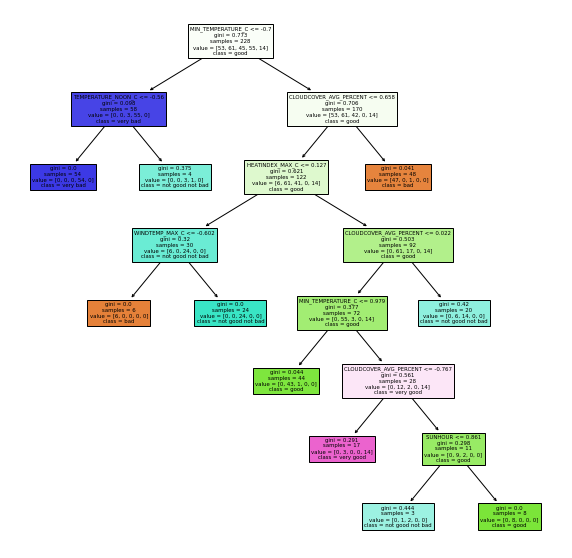

In [25]:
#Visualization indicates that the tree is primarily using the highly correlated variables: 
#CLOUDCOVER_AVG_PERCENT, TEMPERATURE_MORNING_C, MIN_TEMPERATURE_C to make a prediction

plt.figure(figsize = (10,10))
plot_tree(final_model.best_estimator_, filled = True,  
          class_names = final_model.best_estimator_.classes_, 
          feature_names=X_to_pred.columns )

plt.show()

##Additional work: Create features on correlated vars and retrain

In [26]:
#Feature engineering on correlated vals
df_feature = df.copy()

df_feature['cloud_temp'] = df_feature['CLOUDCOVER_AVG_PERCENT']* df_feature['TEMPERATURE_MORNING_C']
df_feature['temp_min'] = df_feature['TEMPERATURE_MORNING_C']* df_feature['MIN_TEMPERATURE_C']
df_feature['min_dew'] = df_feature['CLOUDCOVER_AVG_PERCENT']* df_feature['DEWPOINT_MAX_C']
df_feature['dew_vis'] = df_feature['DEWPOINT_MAX_C']* df_feature['VISIBILITY_AVG_KM']

In [27]:
scaler = StandardScaler()

#X = df.drop(['DATE', 'OPINION', 'MONTH', 'DAY', 'TOTAL_SNOW_MM'], axis=1)
X = df_feature.drop(['DATE', 'OPINION'], axis=1)

y = df_feature['OPINION']

#no scaling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
#scaled data
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42, stratify=y)

In [28]:
#rerun with enhancements - nominal improvements
final_models_feature = []

for k, v in models_to_train.items():
  np.random.seed(42)
  clf = GridSearchCV(k, v, n_jobs=-1, cv=3)
  clf.fit(X_train, y_train)
  print(k)
  print('best cv score', clf.best_score_)
  print('best test score', clf.score(X_test, y_test))
  final_models_feature.append(clf)

GaussianNB(priors=None, var_smoothing=1e-09)
best cv score 0.75
best test score 0.6637168141592921
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
best cv score 0.8508771929824562
best test score 0.8672566371681416
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
best cv score 0.7894736842105262
best test score 0.7787610619469026
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
     

In [30]:
final_model_f = final_models_feature[1]
#predictions_f = final_model_f.best_estimator_.predict(X_to_pred_scaled)

rules_f = [*zip(X.columns, final_model_f.best_estimator_.feature_importances_)]
rules_f.sort(key= lambda x: x[1])
rules_f[-4:]

[('cloud_temp', 0.09443185386361741),
 ('MAX_TEMPERATURE_C', 0.12199672496036436),
 ('CLOUDCOVER_AVG_PERCENT', 0.2412216282468183),
 ('MIN_TEMPERATURE_C', 0.39480634103190926)]

##Additional work: tensorflow with extra feature data

In [31]:
import tensorflow as tf

In [32]:
scaler = StandardScaler()

#X = df.drop(['DATE', 'OPINION', 'MONTH', 'DAY', 'TOTAL_SNOW_MM'], axis=1)
X = df_feature.drop(['DATE', 'OPINION'], axis=1)

y = df_feature['OPINION']
y = pd.get_dummies(y).values

#no scaling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
#scaled data
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42, stratify=y)

In [33]:
dims = X.columns.shape[0]

In [43]:
function = 'relu'
layer1 = 600
layer2 = 50


model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(dims,)),
  tf.keras.layers.Dense(layer1, activation=function),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(layer2, activation=function),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(layer1, activation=function),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(layer2, activation=function),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(layer1, activation=function),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(layer2, activation=function),
  tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [44]:
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15)

Epoch 1/15
8/8 [==============================] - 1s 36ms/step - loss: 0.6489 - accuracy: 0.3061 - val_loss: 0.4739 - val_accuracy: 0.3805
Epoch 2/15
8/8 [==============================] - 0s 11ms/step - loss: 0.4528 - accuracy: 0.4562 - val_loss: 0.3660 - val_accuracy: 0.5664
Epoch 3/15
8/8 [==============================] - 0s 10ms/step - loss: 0.3640 - accuracy: 0.6140 - val_loss: 0.3219 - val_accuracy: 0.6372
Epoch 4/15
8/8 [==============================] - 0s 11ms/step - loss: 0.3199 - accuracy: 0.6014 - val_loss: 0.2795 - val_accuracy: 0.7257
Epoch 5/15
8/8 [==============================] - 0s 11ms/step - loss: 0.2916 - accuracy: 0.6923 - val_loss: 0.2463 - val_accuracy: 0.7257
Epoch 6/15
8/8 [==============================] - 0s 11ms/step - loss: 0.2372 - accuracy: 0.7239 - val_loss: 0.2492 - val_accuracy: 0.6903
Epoch 7/15
8/8 [==============================] - 0s 11ms/step - loss: 0.2266 - accuracy: 0.7523 - val_loss: 0.2489 - val_accuracy: 0.7345
Epoch 8/15
8/8 [===========

In [45]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.2438 - accuracy: 0.7699


[0.24381554126739502, 0.769911527633667]

##After some trials, the model is performant, but unable to outperform the tree